In [2]:
# ⚙️ 必要ライブラリ
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from types import SimpleNamespace
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import ot
from ot.unbalanced import sinkhorn_unbalanced
import os

In [3]:
# ── フォント設定（日本語ラベル用）──────────────────────────────
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
if os.path.exists(font_path):
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams["font.family"] = font_prop.get_name()
else:
    font_prop = None

# ========= notebook parameters =========
args = SimpleNamespace(
    curr         = "../../data/shared/embeddings.npy",   # 既存サービスの埋め込み (n_services × D)
    fut          = "../VAE/emb_new.npy",      # 新規サンプルの埋め込み   (N_new × D)
    # segm         = "../../data/shared/user_segments.csv",# 市場セグメント（学生/高齢者など）
    mass_curr    = None,
    plot_detail  = True,
    sensitivity_analysis = True,   # 感度分析ON/OFF
)

In [4]:
# =============================================================================
# 0. 事前設定
# =============================================================================
from pathlib import Path
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import torch


# args.use_byol を True → 64 dim、False → 33 dim で回す想定
USE_BYOL = getattr(args, "use_byol", False)         # ← ここは argparse などから来る
DATA_DIR      = Path("../../data/shared")
SCALER_PATH   = DATA_DIR / "scaler.gz" # 同じ scaler を常に使う
EMB_EXIST_NPY = DATA_DIR / "embeddings.npy"
EMB_NEW_NPY   = DATA_DIR / "emb_new.npy"

# =============================================================================
# 1. 既存サービス側 ─ 埋め込みを作成またはロード
# =============================================================================
if USE_BYOL:
    # ---------- 64 次元 BYOL ----------
    # 既に学習済みならロード、無ければ学習して保存
    if EMB_EXIST_NPY.exists():
        X_curr = np.load(EMB_EXIST_NPY)
    else:
        # ① feat_df (33 dim) → BYOL 学習 → 64 dim 埋め込み生成
        feat_df = pd.read_pickle(DATA_DIR / "feat_df.pkl")
        X_raw   = torch.tensor(feat_df.values, dtype=torch.float32)
        byol_model = BYOL(input_dim=X_raw.shape[1]).eval()
        with torch.no_grad():
            h, _ = byol_model.online(X_raw)   # (n, 64)
        X_curr = h.numpy()
        np.save(EMB_EXIST_NPY, X_curr)

else:
    # ---------- 33 次元アンケートそのまま ----------
    feat_df = pd.read_pickle(DATA_DIR / "feat_df.pkl")
    X_curr  = feat_df.values.astype(np.float32)
    np.save(EMB_EXIST_NPY, X_curr)            # 以降の処理が同じファイル名を見るので保存

# =============================================================================
# 2. 新サービス側 ─ VAE などで生成（既にファイルがあればロード）
# =============================================================================
if EMB_NEW_NPY.exists():
    Y_fut = np.load(EMB_NEW_NPY)
else:
    # 例：VAE を X_curr と同じ input_dim で学習し、20 サンプル生成
    input_dim = X_curr.shape[1]
    vae = VAE(input_dim=input_dim, hidden_dim=128, latent_dim=16).eval()
    with torch.no_grad():
        z = torch.randn(20, 16)
        Y_fut = vae.decode(z).numpy()         # shape = (20, input_dim)
    np.save(EMB_NEW_NPY, Y_fut)

# =============================================================================
# 3. スケーリング ─ 既存 / 新 を **同じ scaler** で変換
# =============================================================================
if SCALER_PATH.exists():
    scaler = load(SCALER_PATH)
else:
    scaler = StandardScaler().fit(X_curr)     # fit は一度だけ
    dump(scaler, SCALER_PATH)

X_curr = scaler.transform(X_curr)
Y_fut  = scaler.transform(Y_fut)

n = X_curr.shape[0]
m = Y_fut.shape[0]

# ------------------------------------------------------------------------
# 4. ★ ここで必ず次元一致チェック（33 か 64 のどちらか）
# ------------------------------------------------------------------------
assert X_curr.shape[1] == Y_fut.shape[1], \
       f"Dim mismatch: X={X_curr.shape[1]}, Y={Y_fut.shape[1]}"

DIM = X_curr.shape[1]          # この後の距離計算は DIM 次元で統一
print(f"✓ embeddings aligned to {DIM}-dim space")

✓ embeddings aligned to 33-dim space


In [5]:
# # ──────────────────────────────────────────────
# # 2. 質量ベクトルの構造：既存サービス＋非ユーザー＋残留ノード
# #    + 市場セグメント対応
# # ──────────────────────────────────────────────
# xls      = pd.ExcelFile("../../data/定額制動画配信.xlsx")
# df_raw   = pd.read_excel(xls, sheet_name="data")
# format_df= pd.read_excel(xls, sheet_name="Format")

# sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
# code_title = {
#     int(q.split("[")[1].split("]")[0]): title
#     for q, title in zip(sq6_1["Question"], sq6_1["Title"])
# }
# title_code = {v:k for k,v in code_title.items()}

# counts = df_raw["SQ6_2"].value_counts().sort_index()
# shares = counts / counts.sum()

# import pickle
# feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")
# mass_curr = []
# for svc in feat_df.index:
#     code = title_code.get(svc)
#     mass_curr.append(shares.get(code, 0.0))
# mass_curr = np.array(mass_curr, dtype=float)
# service_names = feat_df.index.tolist()

# # 非ユーザーの質量を市場調査や外部統計から決める
# # ここでは例としてセグメント別の未利用率を仮定
# # segment_df = pd.read_csv("../../data/shared/user_segments.csv")  # 例：学生,社会人,高齢者ごとの人口比と未利用率
# # seg_population = segment_df["population"].values
# # seg_nonuser_rate = segment_df["nonuser_rate"].values

# # ── 1) 非利用率 (% ➔ 0-1) ───────────────────────

# nonuser_mass = 0.682 # ICT総研調べ2024–25年時点での 国内「有料 SVOD（定額制動画配信）」 全体の非ユーザー率
# print(f"全国 OTT 非ユーザー率 = {nonuser_mass:.2%}") 

# # ── 5) OT 用の質量ベクトルに組み込む ─────────────
# # 2) ── 質量ベクトル（重複なく１本で） -----------------
# residual_mass = 0.138 # 残留層の質量（クロスマーケティング調べ2023年のインターネット未接続人口）
# a = np.append(mass_curr, [nonuser_mass, residual_mass])
# a = np.maximum(a, 1e-12);  a /= a.sum()           # 正規化
# all_source_names = service_names + ["(非ユーザー)","(残留層)"]

# n = X_curr.shape[0]
# m = Y_fut.shape[0]

# # 複数ARPU、サービスごとの単価も考慮（例）
# # arpu_list = np.loadtxt("../../data/shared/arpu.csv")  # 新サービスごとのARPU仮定（円）

# # arpu.csv をまだ作成していない場合、仮データで進める
# # 仮の ARPU データ
# # arpu_list = np.array([1200, 1500, 1000, 1300, 1600])  # サービスごとの月額単価（仮）

# # セグメント別分析（学生・社会人・高齢者…）のループにも対応可能

# # 複数距離（コサイン×α＋価格差×β＋ブランド差×γ）で複合コスト
# def composite_distance(X, Y, cosine_w=0.6, price_w=0.3, brand_w=0.1):
#     # 仮：price_diff, brand_diffはデータがあれば計算
#     D_cos = pairwise_distances(X, Y, metric="cosine")
#     D_price = np.zeros_like(D_cos)  # 価格差が無い場合は0
#     D_brand = np.zeros_like(D_cos)
#     return (cosine_w * D_cos + price_w * D_price + brand_w * D_brand)

# # ---------------- 外部アンケート -----------------
# # バリア別シェア (%)  × 重み  を足し合わせて raw スコアを作る
# # ICT総研 2025 年調査(出典：ICT総研「2025年 有料動画配信サービス利用動向調査」2025-04-23)
# barrier_share = {
#     "no_intent"   : 0.412,   # 興味がない
#     "few_titles"  : 0.295,   # 見たい作品が少ない
#     "procedure"   : 0.118,   # 登録が面倒
#     "price"       : 0.106,   # 高い
# }
# barrier_weight = {"no_intent":1.0,   "few_titles":0.7,
#                   "procedure":0.5,   "price":0.5}

# D_nonuser_base = sum(barrier_share[k]*barrier_weight[k] for k in barrier_share)   # ≒0.46
# median_d = np.median(pairwise_distances(X_curr, metric="cosine"))  # ≒0.40
# D_nonuser_norm = D_nonuser_base / median_d                         # ≒1.15


# # # パラメータ感度分析用の設定
# # param_grid = {
# #     "nonuser_mass"   : [nonuser_mass*0.7, nonuser_mass, nonuser_mass*1.3],
# #     "D_factor"       : [0.8, 1.0, 1.2],              # 🔴 倍率で回す
# #     "residual_mass"  : [0.10, 0.14, 0.18],
# #     "eps"            : [0.1, 0.2, 0.3],
# #     "tau"            : [0.05, 0.1, 0.2]
# # }

# eps= 0.2  # OT の正則化パラメータ
# tau = 0.1 # 残留層の重み付けパラメータ

# ARPU_FIXED = 1_000          # 円／月　← 全サービス共通で固定
# # ── 全体市場ユーザー数を算出 ────────────────────
# total_market_size = int(124500000 * (1 - residual_mass)) # 2023年の総人口1.245億人から残留層を引く

# print(f"▶ total_market_size = {total_market_size:,} 人")

In [6]:
# ---------------- 基本パラメータ ----------------
TOTAL_POPULATION = 124_500_000          # 2023年の日本の総人口
residual_mass    = 0.138                # ネット未接続（残留層）
nonuser_total    = 0.682                # 総人口ベースの非ユーザー率

# オンライン非ユーザー質量（= 総非ユーザー – 残留層）
nonuser_mass = max(nonuser_total - residual_mass, 0)   # 0.544
user_mass    = 1 - nonuser_total                       # 0.318 (=既存利用者全体)

print(f"オンライン非ユーザー質量 = {nonuser_mass:.3f}")
print(f"既存ユーザー質量       = {user_mass:.3f}")

# ---------- 既存サービスの質量を 0.318 に合わせてスケール ----------
# # ──────────────────────────────────────────────
# # 2. 質量ベクトルの構造：既存サービス＋非ユーザー＋残留ノード
# #    + 市場セグメント対応
# # ──────────────────────────────────────────────
xls      = pd.ExcelFile("../../data/定額制動画配信.xlsx")
df_raw   = pd.read_excel(xls, sheet_name="data")
format_df= pd.read_excel(xls, sheet_name="Format")

sq6_1 = format_df[format_df["Question"].astype(str).str.startswith("SQ6_1[")][["Question","Title"]].dropna()
code_title = {
    int(q.split("[")[1].split("]")[0]): title
    for q, title in zip(sq6_1["Question"], sq6_1["Title"])
}
title_code = {v:k for k,v in code_title.items()}
counts = df_raw["SQ6_2"].value_counts().sort_index()
shares = counts / counts.sum()
mass_curr_scaled = shares * user_mass                  # shares は既存サービス内の比率
a_vec = np.append(mass_curr_scaled, [nonuser_mass, residual_mass])
a_vec /= a_vec.sum()                                   # 念のため正規化

# ---------- 人口スケール ----------
total_market_size = int(TOTAL_POPULATION * (1 - residual_mass))
ARPU = 1_000                                           # 円／月で固定

# ---------------- 外部アンケート -----------------
# バリア別シェア (%)  × 重み  を足し合わせて raw スコアを作る
# ICT総研 2025 年調査(出典：ICT総研「2025年 有料動画配信サービス利用動向調査」2025-04-23)
barrier_share = {
    "no_intent"   : 0.412,   # 興味がない
    "few_titles"  : 0.295,   # 見たい作品が少ない
    "procedure"   : 0.118,   # 登録が面倒
    "price"       : 0.106,   # 高い
}
barrier_weight = {"no_intent":1.0,   "few_titles":0.7,
                  "procedure":0.5,   "price":0.5}

D_nonuser_base = sum(barrier_share[k]*barrier_weight[k] for k in barrier_share)   
median_d = np.median(pairwise_distances(X_curr, metric="cosine"))  
D_nonuser_norm = 1.75
# D_nonuser_norm = D_nonuser_base / median_d     
print(f"非ユーザーの距離（ベース） = {D_nonuser_base:.3f}")
print(f"非ユーザーの距離（中央値） = {median_d:.3f}")                  
print(f"非ユーザーの距離（正規化） = {D_nonuser_norm:.3f}")

# ---------------------------------------------------------------
def run_ot_for_candidate(idx, eps=0.2, tau=0.1):
    Y_single = Y_fut[idx].reshape(1, -1)

    # 距離行列（コサインのみで OK なら composite をシンプル化）
    D_existing   = pairwise_distances(X_curr, Y_single, metric="cosine")
    D_nonuser_arr = np.array([[D_nonuser_norm]])   # 非ユーザー→新サービス
    D_resid_arr   = np.array([[2.0]])              # 残留層→新サービス（ほぼ動かない）

    D = np.vstack([D_existing, D_nonuser_arr, D_resid_arr])
    D = D / np.median(D)

    b = np.array([1.0])  # 1 つの新サービス

    T = sinkhorn_unbalanced(a_vec, b, D, reg=eps, reg_m=tau)

    inbound_total = T.sum()
    inbound_users = inbound_total * total_market_size      # ← 人数スケールはここでだけ

    from_existing = T[:-2, 0].sum() * total_market_size
    from_nonuser  = T[-2, 0]    * total_market_size
    # 残留層は人数化してもほぼ 0 の想定
    novelty       = D_existing.min()
    blue_score    = T[-2, 0] * novelty                     # “非ユーザー×新規性”

    sales = inbound_users * ARPU

    return {
        "service"        : f"new{idx}",
        "users_existing" : int(from_existing),
        "users_nonuser"  : int(from_nonuser),
        "total_users"    : int(inbound_users),
        "blue_score"     : blue_score,
        "novelty"        : novelty,
        "sales_JPY"      : int(sales)
    }

#     return {
#         "service": f"new{idx}",
#         "from_existing": from_existing * total_market_size,
#         "from_nonuser": from_nonuser * total_market_size,
#         "from_residual": from_residual * total_market_size,
#         "residual_ratio": residual_ratio,
#         "total_inflow": inbound_users,
#         "nonuser_ratio": bo_ratio,
#         "novelty": novelty,
#         "BlueOceanScore": blue_score,
#         "estimated_sales": estimated_sales,
#         "arpu": ARPU_FIXED,  # 円／月
#         "eps": eps,
#         "tau": tau,
#         "nonuser_mass": nonuser_mass,
#         "D_nonuser": float(D_nonuser_arr),
#         "residual_mass": residual_mass
#     }

# ---------- 実行 ----------
results = [run_ot_for_candidate(i) for i in range(m)]
df_result = pd.DataFrame(results)
df_result.to_csv("results/scores_fixed.csv", index=False)
print("✓ results/scores_fixed.csv に保存しました")

オンライン非ユーザー質量 = 0.544
既存ユーザー質量       = 0.318
非ユーザーの距離（ベース） = 0.731
非ユーザーの距離（中央値） = 1.063
非ユーザーの距離（正規化） = 1.750
✓ results/scores_fixed.csv に保存しました


In [7]:



# # =============================================================
# # 3. 新サービス候補1つずつに対してOTを実施 + パラメータ感度分析
# # =============================================================

# def run_ot_for_candidate(idx, nonuser_mass, D_nonuser_norm, residual_mass, eps, tau):
#     # 新サービスベクトル
#     Y_single = Y_fut[idx].reshape(1, -1)
#     # composite distance
#     D_existing = composite_distance(X_curr, Y_single, cosine_w=0.7, price_w=0.2, brand_w=0.1)  # (n,1)
#     # 非ユーザーと残留層から新サービスへのコスト（現実的ならセグメント別に分けて実装）
#     D_nonuser_arr = np.array([[D_nonuser_norm]])  # 非ユーザーからの距離（コスト）
#     D_resid_arr   = np.array([[2.0]])   # 残留層は「絶対動かない」ので大きめコスト
#     D = np.vstack([D_existing, D_nonuser_arr, D_resid_arr])  # (n+2, 1)
#     D = D / np.median(D)

#     # 質量ベクトル
#     a_vec = np.append(np.maximum(mass_curr, 1e-12), [nonuser_mass, residual_mass])
#     a_vec /= a_vec.sum()

#     b = np.array([1.0])  # 1サービスだけに1

#     # OT計算
#     T = sinkhorn_unbalanced(a_vec, b, D, reg=eps, reg_m=tau)
#     inbound_total  = T.sum()
#     inbound_users  = inbound_total * total_market_size

#     from_existing  = T[:-2, 0].sum()
#     from_nonuser   = T[-2, 0]
#     from_residual  = T[-1, 0]
#     bo_ratio = from_nonuser / inbound_total if inbound_total > 0 else 0
#     residual_ratio = from_residual / inbound_total if inbound_total > 0 else 0

#     # Novelty
#     novelty = D_existing.min()

#     # ブルーオーシャンスコア
#     blue_score = from_nonuser * novelty

#     # 売上予測
#     estimated_sales = inbound_users * ARPU_FIXED

#     return {
#         "service": f"new{idx}",
#         "from_existing": from_existing * total_market_size,
#         "from_nonuser": from_nonuser * total_market_size,
#         "from_residual": from_residual * total_market_size,
#         "residual_ratio": residual_ratio,
#         "total_inflow": inbound_users,
#         "nonuser_ratio": bo_ratio,
#         "novelty": novelty,
#         "BlueOceanScore": blue_score,
#         "estimated_sales": estimated_sales,
#         "arpu": ARPU_FIXED,  # 円／月
#         "eps": eps,
#         "tau": tau,
#         "nonuser_mass": nonuser_mass,
#         "D_nonuser": float(D_nonuser_arr),
#         "residual_mass": residual_mass
#     }

# # ----- 感度分析を使わない -----
# results = []
# for idx in range(m):
#     res = run_ot_for_candidate(
#         idx, nonuser_mass, D_nonuser_norm, residual_mass=residual_mass,
#         eps=0.2, tau=0.1)
#     results.append(res)
# df_result = pd.DataFrame(results)
# df_result.to_csv("results/scores.csv", index=False)

=== Blue-Ocean Score TOP10 ===


,service,users_existing,users_nonuser,total_users,blue_score,novelty,sales_JPY
9,new9,4989221,853112,5945436,0.003473,0.436840,5945436977
7,new7,5423647,812624,6334096,0.002816,0.371833,6334096303
0,new0,5572642,820335,6491980,0.002697,0.352825,6491980110
6,new6,4476307,638361,5188209,0.002628,0.441798,5188209495
14,new14,5233144,705947,6022182,0.002507,0.381124,6022182801
8,new8,5387120,709498,6180291,0.002247,0.339816,6180291365
4,new4,4761537,506872,5324980,0.001823,0.385963,5324980167
15,new15,4730362,482710,5266542,0.001784,0.396614,5266542515
1,new1,5072652,458062,5581215,0.001341,0.314071,5581215562
16,new16,5055338,458328,5564193,0.001297,0.303716,5564193455


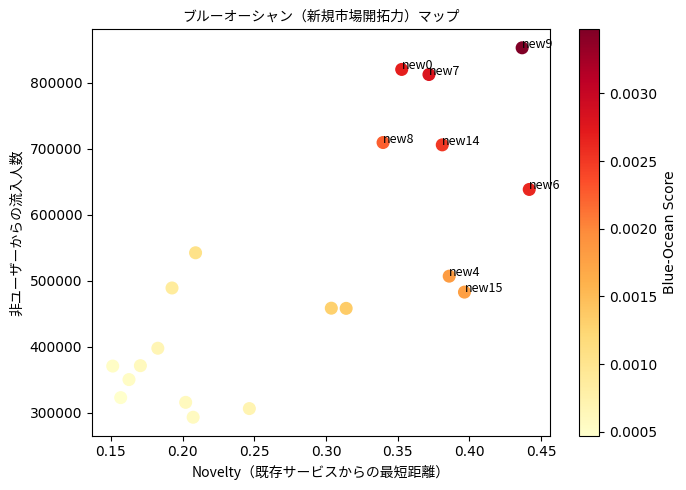

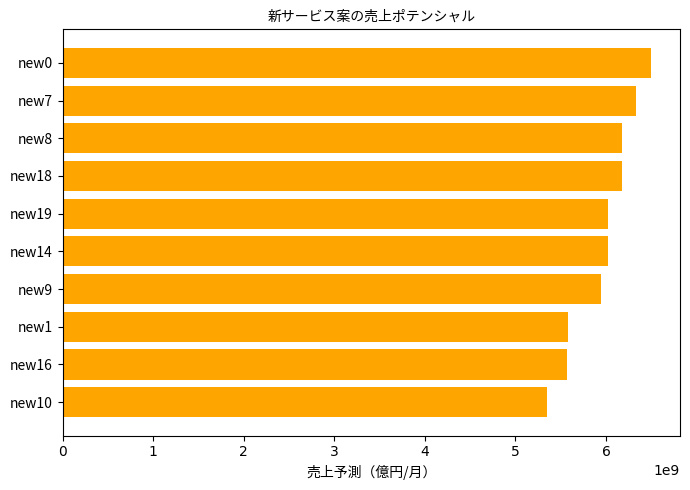

In [8]:
# =============================================================
# 4. 可視化・ランキング出力
# =============================================================

print("=== Blue-Ocean Score TOP10 ===")
display(df_result.sort_values("blue_score", ascending=False).head(10))

plt.figure(figsize=(7,5))
plt.scatter(df_result["novelty"], df_result["users_nonuser"], 
            c=df_result["blue_score"], cmap="YlOrRd", s=70)
plt.colorbar(label="Blue-Ocean Score")
for _, row in df_result.sort_values("blue_score", ascending=False).head(8).iterrows():
    plt.text(row.novelty, row.users_nonuser, row.service, fontsize=9,
             fontproperties=font_prop)
plt.xlabel("Novelty（既存サービスからの最短距離）", fontproperties=font_prop)
plt.ylabel("非ユーザーからの流入人数", fontproperties=font_prop)
plt.title("ブルーオーシャン（新規市場開拓力）マップ", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# 売上予測上位
plt.figure(figsize=(7,5))
order = np.argsort(df_result["sales_JPY"])[::-1][:10]
plt.barh(range(10), df_result.iloc[order]["sales_JPY"], color="orange")
plt.yticks(range(10), df_result.iloc[order]["service"], fontproperties=font_prop)
plt.xlabel("売上予測（億円/月）", fontproperties=font_prop)
plt.title("新サービス案の売上ポテンシャル", fontproperties=font_prop)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# # 感度分析結果ヒートマップ（例：パラメータごと最大値など集約）
# if args.sensitivity_analysis:
#     pivot = df_result.pivot_table(index="service", columns="nonuser_mass", values="blue_score", aggfunc="max")
#     plt.figure(figsize=(12,6))
#     sns.heatmap(pivot, cmap="YlOrRd")
#     plt.title("Blue-Ocean Score 感度分析（非ユーザー率ごと）", fontproperties=font_prop)
#     plt.ylabel("サービス", fontproperties=font_prop)
#     plt.xlabel("非ユーザー率", fontproperties=font_prop)
#     plt.tight_layout()
#     plt.show()

In [9]:
print("Y_fut shape:", Y_fut.shape)
print("feat_df shape:", feat_df.shape)
print("feat_df.columns:", feat_df.columns.tolist())

Y_fut shape: (20, 33)
feat_df shape: (20, 33)
feat_df.columns: ['UX_mean', 'UI_design', 'Player_usability', 'Catalogue_volume', 'Genre_coverage_within_category', 'New_release_speed', 'Genre_coverage_among_category', 'Cost_perf', 'Overall_satisfaction', 'NPS_intention', 'Continue_intention', 'Genre_1_top_share', 'Genre_2_top_share', 'Genre_3_top_share', 'Genre_4_top_share', 'Genre_5_top_share', 'Genre_6_top_share', 'Genre_7_top_share', 'Genre_8_top_share', 'Genre_9_top_share', 'Genre_10_top_share', 'Genre_11_top_share', 'Genre_12_top_share', 'Genre_13_top_share', 'Genre_14_top_share', 'Genre_15_top_share', 'Original_viewer_share', 'Original_quality', 'Usage_tenure_months', 'Personal_pay_ratio', 'Extra_service_use', 'Corporate_trust', 'SDGs_influence']


In [18]:
# 表示オプションの設定
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Y_fut = pd.DataFrame(Y_fut, columns=feat_df.columns)  # feat_df のカラム名を使う
# 新サービスのインデックスを "new0", "new1", ... に変更
Y_fut.index = [f"new{i}" for i in range(Y_fut.shape[0])]
display(Y_fut)

,UX_mean,UI_design,Player_usability,Catalogue_volume,Genre_coverage_within_category,New_release_speed,Genre_coverage_among_category,Cost_perf,Overall_satisfaction,NPS_intention,Continue_intention,Genre_1_top_share,Genre_2_top_share,Genre_3_top_share,Genre_4_top_share,Genre_5_top_share,Genre_6_top_share,Genre_7_top_share,Genre_8_top_share,Genre_9_top_share,Genre_10_top_share,Genre_11_top_share,Genre_12_top_share,Genre_13_top_share,Genre_14_top_share,Genre_15_top_share,Original_viewer_share,Original_quality,Usage_tenure_months,Personal_pay_ratio,Extra_service_use,Corporate_trust,SDGs_influence
new0,-12.097788,-10.764561,-10.099566,-8.333474,-7.505490,-9.887557,-1.471729,-8.301219,-10.579298,-8.550198,-9.445761,-1.345722,-2.575586,0.276587,0.430255,1.442929,-1.002102,-6.417120,0.310468,7.708804,-16.097841,-0.321860,0.042537,-0.123407,5.112283,-0.146773,-0.099200,-18.081015,-3.156902,-1.081252,-1.064989,-10.618526,-5.282065
new1,-13.252297,-11.121427,-11.712041,-9.035687,-7.900412,-10.209789,-1.772051,-9.853962,-12.331333,-9.226117,-10.681283,-0.259617,-1.231974,-0.177375,0.106618,-0.588847,-0.678967,0.321625,0.297694,10.063431,-1.886571,-0.686542,0.112838,0.018363,2.382308,-0.075929,-0.098308,-19.396637,-3.534906,-1.108872,-0.881237,-11.700355,-5.859439
new2,-12.973888,-10.829726,-11.922254,-8.874615,-7.527673,-9.811936,-1.425812,-9.364319,-12.037398,-8.431255,-10.751997,1.148474,-2.302051,-1.514163,-1.531709,0.888322,-0.406104,-1.004416,1.041109,13.171699,31.318623,-0.511072,0.150563,0.166083,-0.509059,-0.303465,0.188877,-18.326481,-3.278422,-1.305876,-0.957277,-11.192166,-5.882139
new3,-10.223915,-8.810009,-9.383537,-7.399326,-7.094414,-8.579448,-1.688252,-7.767390,-9.654860,-7.812137,-8.377630,-0.180954,0.796103,-1.233400,-1.345164,-2.208711,-1.011437,-2.079868,0.379033,3.541732,31.856361,-0.057720,0.202403,0.137941,-0.447104,-0.204216,0.076960,-16.195108,-2.878410,-0.838041,-0.637297,-10.007816,-4.851748
new4,-12.086559,-10.197411,-10.336488,-8.001885,-6.917569,-8.737161,-1.533577,-8.405962,-10.575208,-7.519580,-9.307745,-0.271427,0.830151,-2.087790,0.060763,1.303558,-0.673983,0.942473,0.361001,14.868328,-9.300613,-0.164475,0.033024,-0.048473,1.137025,0.110206,-0.304622,-16.665245,-3.055642,-1.042639,-1.079293,-9.961815,-5.403534
new5,-12.743970,-10.785810,-10.938116,-8.847157,-7.571371,-9.696083,-1.725367,-9.199457,-11.503251,-8.227781,-10.059393,-0.231434,-0.181042,-1.613828,0.093420,-0.672319,-0.751634,-0.799320,0.259485,15.364697,13.038475,-0.202449,0.064775,-0.042862,-0.453270,0.009370,-0.023712,-18.271154,-3.106990,-0.995208,-1.076492,-10.996792,-5.824966
new6,-9.422839,-7.870183,-8.597306,-6.449781,-5.524341,-6.737580,-1.149636,-6.906923,-8.554647,-5.952380,-7.470991,1.611353,-1.033590,-1.597483,-0.893703,1.118242,-1.010887,7.151176,-0.600135,7.787361,-22.344927,0.339849,0.017010,0.042306,-0.492156,0.055577,-0.199663,-14.205135,-2.145294,-0.954818,-1.323843,-7.654806,-4.565294
new7,-11.857056,-10.086094,-10.689326,-8.152865,-7.641871,-9.948442,-1.343436,-9.401178,-11.217780,-8.576914,-9.916220,0.133066,0.649858,0.615826,-0.386680,-1.531280,-0.570010,-2.309062,0.926961,1.963339,-21.995886,-0.976864,-0.053009,0.068661,5.400702,-0.088812,-0.149786,-18.588411,-3.376888,-1.123763,-0.811219,-10.714050,-5.170592
new8,-11.448174,-9.537791,-9.755961,-8.241544,-6.853606,-8.623363,-1.521033,-7.966270,-10.225602,-7.310423,-8.789162,1.294057,-2.667593,-0.298963,0.358673,2.340855,-0.849658,1.086266,1.733569,5.366934,-12.385672,0.465837,0.140431,0.028424,1.480508,-0.275300,-0.116733,-16.868557,-3.114605,-0.830418,-0.396339,-10.004333,-4.665904
new9,-9.739886,-8.134339,-8.501978,-7.200539,-5.062047,-6.541281,-1.573132,-6.764777,-8.380860,-5.857701,-7.315170,1.516743,-1.119230,0.382086,0.933700,-0.306434,-0.713869,5.510514,1.063588,2.472875,-23.154135,0.584149,0.247785,0.225400,4.290220,-0.118819,-0.177830,-14.146751,-2.695105,-0.522246,-0.468276,-8.152933,-3.894094


In [11]:
# from sklearn.neural_network import MLPRegressor
# import pandas as pd
# import numpy as np

# Y_fut  = np.load(args.fut)

# # 既存のサービスの埋め込み（64次元）と対応する33次元特徴量
# X_train = np.load("../../data/shared/embeddings.npy")  # 64次元のBYOL特徴量
# feat_df = pd.read_pickle("../../data/shared/feat_df.pkl")  # 33次元の元の特徴量

# y_train = feat_df.values  # 33次元の元の特徴量

# # MLP回帰を学習
# reg = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500)
# reg.fit(X_train, y_train)

# # 新しいサービス（64次元）の特徴量を予測
# X_new = reg.predict(Y_fut)  # Y_futは64次元の新サービス埋め込み


In [12]:
# # 新サービスの特徴量をデータフレーム化
# new_service_df = pd.DataFrame(X_new, columns=feat_df.columns)

# # 各特徴量を可視化（ヒストグラムなど）
# new_service_df.hist(figsize=(12, 10), bins=20)
# plt.suptitle('Distribution of Predicted Features for New Services')
# plt.tight_layout()
# plt.show()

In [13]:
# # 新サービスと元のサービスの特徴量の平均差を計算
# avg_diff = np.abs(feat_df.values - X_new).mean(axis=0)

# # 最も差分が大きい特徴量を表示
# top_diff_indices = np.argsort(avg_diff)[::-1][:10]
# print("New service's most distinctive features:")
# for idx in top_diff_indices:
#     print(f"{feat_df.columns[idx]}: Difference {avg_diff[idx]:.3f}")


In [14]:
# # 省略せずに全列・全行を表示する設定
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
# new_service_df

In [15]:
# # ── ① new15 の行を取り出す ──────────────────────────
# row15 = df_result.query("service == 'new15'").iloc[0]

# # ── ② 流入人数に変換（率 × 市場規模） ────────────────
# #     ※ すでに run_ot_for_candidate() 内で total_market_size を掛けて
# #       'total_inflow' に絶対人数が入っている場合は↓不要
# inbound_users = row15["total_inflow"]                 # 人
# print(f"想定流入人数: {inbound_users:,.0f} 人")

# # ── ③ 単価を掛けて月次／累計売上を推計 ──────────────
# monthly_fee      = 690           # 円
# avg_tenure_month = 17.7          # 月
# monthly_sales    = inbound_users * monthly_fee
# lifetime_sales   = monthly_sales * avg_tenure_month

# print(f"月次売上予測 : ¥{monthly_sales:,.0f}")
# print(f"LTV 売上予測: ¥{lifetime_sales:,.0f}  (継続 {avg_tenure_month} ヵ月)")


累積寄与率: 0.991


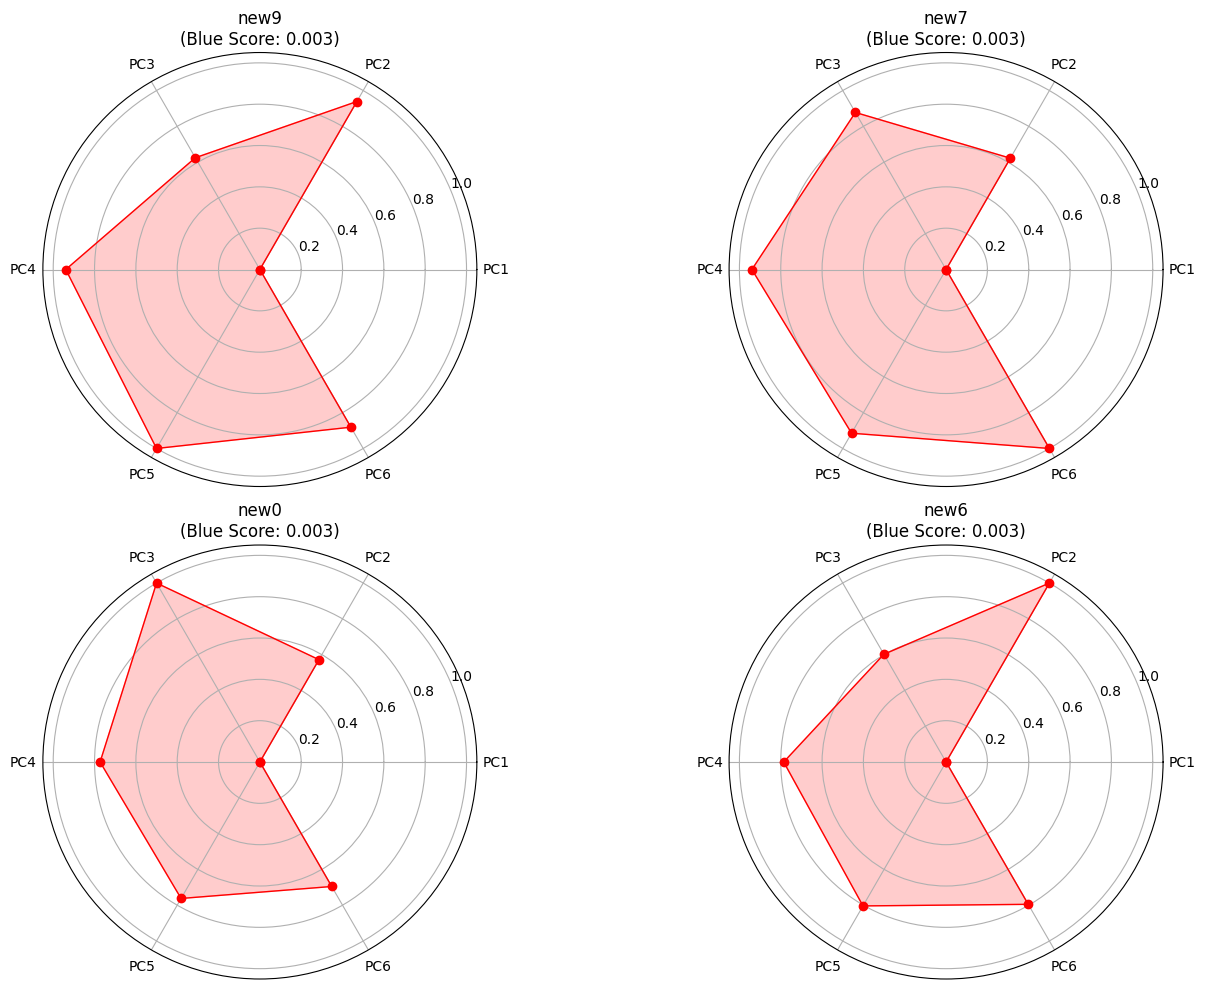

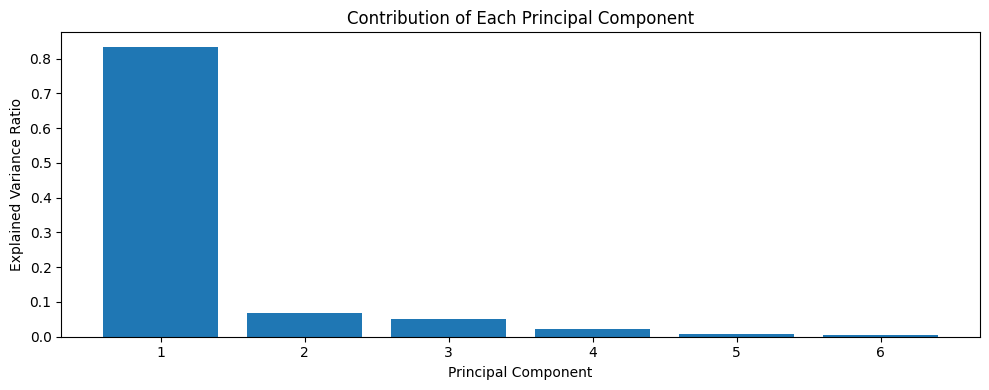


各主成分における上位3特徴量:

PC1:
  Genre_10_top_share: 0.994
  Original_quality: 0.038
  Genre_14_top_share: 0.036

PC2:
  Genre_9_top_share: 0.621
  Genre_7_top_share: 0.532
  Genre_14_top_share: 0.428

PC3:
  Genre_9_top_share: 0.707
  Genre_7_top_share: 0.472
  Original_quality: 0.212

PC4:
  Genre_7_top_share: 0.533
  Genre_2_top_share: 0.464
  Original_quality: 0.276

PC5:
  Genre_14_top_share: 0.771
  Genre_2_top_share: 0.331
  Genre_7_top_share: 0.325

PC6:
  Genre_2_top_share: 0.533
  Genre_5_top_share: 0.469
  Genre_14_top_share: 0.383


In [16]:
# PCAとレーダーチャートの作成
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import math

# PCAの実行（6成分に圧縮）
n_components = 6
pca = PCA(n_components=n_components)
Y_fut_pca = pca.fit_transform(Y_fut)

# 累積寄与率を確認
explained_ratio = pca.explained_variance_ratio_
cumsum_ratio = np.cumsum(explained_ratio)
print(f"累積寄与率: {cumsum_ratio[-1]:.3f}")

# レーダーチャートの描画関数
def plot_hexagonal_radar(values, ax=None, title=None, color='red', alpha=0.2):
    """六角形のレーダーチャートを描画"""
    angles = np.linspace(0, 2*np.pi, 6, endpoint=False)
    values = np.concatenate((values, [values[0]]))  # 最初の値を最後にも追加して閉じる
    angles = np.concatenate((angles, [angles[0]]))  # 同上
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))
    
    ax.plot(angles, values, 'o-', color=color, linewidth=1)
    ax.fill(angles, values, alpha=alpha, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f'PC{i+1}' for i in range(6)])
    if title:
        ax.set_title(title)
    return ax

# 上位N個のサービスを可視化
N = 4
top_services = df_result.sort_values('blue_score', ascending=False)['service'].head(N).values

# サブプロットの設定
fig = plt.figure(figsize=(15, 10))
cols = 2
rows = math.ceil(N/cols)

# 各サービスの特徴を可視化
for i, service in enumerate(top_services, 1):
    ax = plt.subplot(rows, cols, i, projection='polar')
    values = Y_fut_pca[int(service.replace('new', ''))]
    
    # 値を0-1にスケーリング
    values_scaled = (values - values.min()) / (values.max() - values.min())
    
    # レーダーチャート描画
    plot_hexagonal_radar(values_scaled, ax=ax, 
                        title=f"{service}\n(Blue Score: {df_result.loc[df_result['service']==service, 'blue_score'].values[0]:.3f})")

plt.tight_layout()
plt.show()

# 主成分の寄与度を棒グラフで可視化
plt.figure(figsize=(10, 4))
plt.bar(range(1, n_components+1), explained_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Contribution of Each Principal Component')
plt.tight_layout()
plt.show()

# 各主成分の特徴量寄与度
component_df = pd.DataFrame(
    pca.components_,
    columns=Y_fut.columns,
    index=[f'PC{i+1}' for i in range(n_components)]
)

print("\n各主成分における上位3特徴量:")
for pc in component_df.index:
    top3 = component_df.loc[pc].abs().nlargest(3)
    print(f"\n{pc}:")
    for feat, val in top3.items():
        print(f"  {feat}: {val:.3f}")